# 📊 Preprocesiranje podataka

In [5]:
import yfinance as yf

In [92]:
# Preuzimamo S&P 500 od 2020. do 2025.
sp500 = yf.download("^GSPC", start="2020-01-01", end="2025-09-01", interval="1d", auto_adjust = False)

print(sp500.head())

[*********************100%***********************]  1 of 1 completed

Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2020-01-02  3257.850098  3257.850098  3258.139893  3235.530029  3244.669922   
2020-01-03  3234.850098  3234.850098  3246.149902  3222.340088  3226.360107   
2020-01-06  3246.280029  3246.280029  3246.840088  3214.639893  3217.550049   
2020-01-07  3237.179932  3237.179932  3244.909912  3232.429932  3241.860107   
2020-01-08  3253.050049  3253.050049  3267.070068  3236.669922  3238.590088   

Price           Volume  
Ticker           ^GSPC  
Date                    
2020-01-02  3459930000  
2020-01-03  3484700000  
2020-01-06  3702460000  
2020-01-07  3435910000  
2020-01-08  3726840000  


In [93]:
sp500 = sp500.reset_index()

In [94]:
print(sp500.head())      # prvih 5 redova
print(sp500.tail())      # poslednjih 5 redova
print(sp500.columns)     # nazivi kolona

Price        Date    Adj Close        Close         High          Low  \
Ticker                   ^GSPC        ^GSPC        ^GSPC        ^GSPC   
0      2020-01-02  3257.850098  3257.850098  3258.139893  3235.530029   
1      2020-01-03  3234.850098  3234.850098  3246.149902  3222.340088   
2      2020-01-06  3246.280029  3246.280029  3246.840088  3214.639893   
3      2020-01-07  3237.179932  3237.179932  3244.909912  3232.429932   
4      2020-01-08  3253.050049  3253.050049  3267.070068  3236.669922   

Price          Open      Volume  
Ticker        ^GSPC       ^GSPC  
0       3244.669922  3459930000  
1       3226.360107  3484700000  
2       3217.550049  3702460000  
3       3241.860107  3435910000  
4       3238.590088  3726840000  
Price        Date    Adj Close        Close         High          Low  \
Ticker                   ^GSPC        ^GSPC        ^GSPC        ^GSPC   
1418   2025-08-25  6439.319824  6439.319824  6466.890137  6438.060059   
1419   2025-08-26  6465.939941 

In [45]:
print(sp500.shape)

(1423, 6)


In [95]:
# 1. Broj nedostajućih vrednosti po koloni
print(sp500.isnull().sum())

# 2. Da li ceo DataFrame ima NaN vrednosti
print(sp500.isnull().values.any())

# 3. Ukupan broj NaN vrednosti
print(sp500.isnull().sum().sum())

Price      Ticker
Date                 0
Adj Close  ^GSPC     0
Close      ^GSPC     0
High       ^GSPC     0
Low        ^GSPC     0
Open       ^GSPC     0
Volume     ^GSPC     0
dtype: int64
False
0


In [96]:
# Spajanje u jedan nivo
sp500 = sp500.copy()
sp500.columns = sp500.columns.droplevel(1)  # skida drugi nivo (^GSPC)

print(sp500.head())

Price       Date    Adj Close        Close         High          Low  \
0     2020-01-02  3257.850098  3257.850098  3258.139893  3235.530029   
1     2020-01-03  3234.850098  3234.850098  3246.149902  3222.340088   
2     2020-01-06  3246.280029  3246.280029  3246.840088  3214.639893   
3     2020-01-07  3237.179932  3237.179932  3244.909912  3232.429932   
4     2020-01-08  3253.050049  3253.050049  3267.070068  3236.669922   

Price         Open      Volume  
0      3244.669922  3459930000  
1      3226.360107  3484700000  
2      3217.550049  3702460000  
3      3241.860107  3435910000  
4      3238.590088  3726840000  


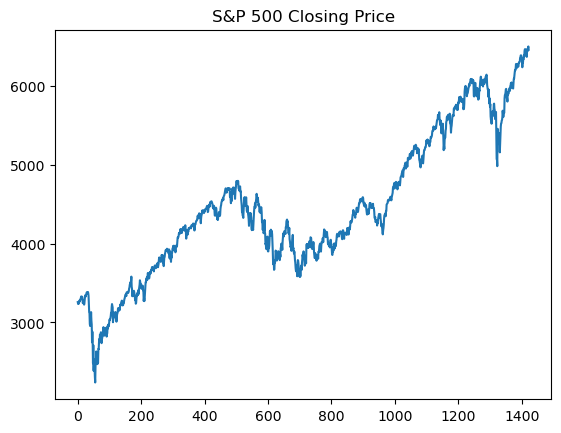

In [97]:
import matplotlib.pyplot as plt

sp500["Close"].plot(title="S&P 500 Closing Price")
plt.show()

# Dodavanje indikatora 

#### Avg_Price

In [98]:
sp500['Avg_Price'] = (sp500['Close'] + sp500['Open'] + sp500['High']+ sp500['Low'])/4.0

#### Dodavanje svih indikatora

In [99]:
sp500.columns.tolist()

['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Avg_Price']

In [100]:
def calculate_technical_indicators_advanced(df, price_columns=None, 
                                          rsi_window=14, macd_fast=14, 
                                          macd_slow=42, macd_signal=9,
                                          bb_window=14, bb_dev=2,
                                          atr_window=14, obv_window=14):
    if price_columns is None:
        price_columns = ['High', 'Low', 'Open', 'Close', 'Avg_Price']
    
    result_df = df.copy()
    
    for price_col in price_columns:
        # 1. EMA-SMA Diff
        SMA = result_df[price_col].rolling(window=rsi_window).mean()
        EMA = result_df[price_col].ewm(span=rsi_window, adjust=False).mean()
        result_df[f'EMA_SMA_Diff_{price_col}'] = EMA - SMA
        
        # 2. RSI
        result_df[f'RSI_{price_col}'] = ta.momentum.RSIIndicator(
            close=result_df[price_col], window=rsi_window
        ).rsi()
        
        # 3. MACD
        macd = ta.trend.MACD(
            close=result_df[price_col], 
            window_slow=macd_slow, 
            window_fast=macd_fast, 
            window_sign=macd_signal
        )
        result_df[f'MACD_{price_col}'] = macd.macd()
        result_df[f'MACD_Diff_{price_col}'] = macd.macd_diff()
        
        # 4. Bollinger Bands
        bollinger = ta.volatility.BollingerBands(
            close=result_df[price_col], 
            window=bb_window, 
            window_dev=bb_dev
        )
        Bollinger_High = bollinger.bollinger_hband()
        Bollinger_Low = bollinger.bollinger_lband()
        result_df[f'Bollinger_BB_{price_col}'] = Bollinger_High - Bollinger_Low
        
        # 5. ATR
        atr = ta.volatility.AverageTrueRange(
            high=result_df['High'],
            low=result_df['Low'],
            close=result_df[price_col],
            window=atr_window
        )
        result_df[f'ATR_{price_col}'] = atr.average_true_range()
        
        # 6. OBV
        obv = ta.volume.OnBalanceVolumeIndicator(
            close=result_df[price_col],
            volume=result_df['Volume']
        )
        OBV = obv.on_balance_volume()
        result_df[f'OBV{obv_window}_{price_col}'] = OBV.rolling(window=obv_window).mean()
    
    return result_df

# Primer korišćenja sa custom parametrima:
# sp500 = calculate_technical_indicators_advanced(
#     sp500, 
#     price_columns=['Close', 'Avg_Price'],
#     rsi_window=14,
#     macd_fast=12,
#     macd_slow=26,
#     macd_signal=9
# )

In [101]:
sp500_ind = calculate_technical_indicators_advanced(sp500)

In [102]:
sp500_ind.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,Avg_Price,EMA_SMA_Diff_High,RSI_High,...,Bollinger_BB_Close,ATR_Close,OBV14_Close,EMA_SMA_Diff_Avg_Price,RSI_Avg_Price,MACD_Avg_Price,MACD_Diff_Avg_Price,Bollinger_BB_Avg_Price,ATR_Avg_Price,OBV14_Avg_Price
0,2020-01-02,3257.850098,3257.850098,3258.139893,3235.530029,3244.669922,3459930000,3249.047485,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,2020-01-03,3234.850098,3234.850098,3246.149902,3222.340088,3226.360107,3484700000,3232.425049,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,2020-01-06,3246.280029,3246.280029,3246.840088,3214.639893,3217.550049,3702460000,3231.327515,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,2020-01-07,3237.179932,3237.179932,3244.909912,3232.429932,3241.860107,3435910000,3239.094971,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,2020-01-08,3253.050049,3253.050049,3267.070068,3236.669922,3238.590088,3726840000,3248.845032,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [103]:
sp500_ind.columns.tolist()

['Date',
 'Adj Close',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'Avg_Price',
 'EMA_SMA_Diff_High',
 'RSI_High',
 'MACD_High',
 'MACD_Diff_High',
 'Bollinger_BB_High',
 'ATR_High',
 'OBV14_High',
 'EMA_SMA_Diff_Low',
 'RSI_Low',
 'MACD_Low',
 'MACD_Diff_Low',
 'Bollinger_BB_Low',
 'ATR_Low',
 'OBV14_Low',
 'EMA_SMA_Diff_Open',
 'RSI_Open',
 'MACD_Open',
 'MACD_Diff_Open',
 'Bollinger_BB_Open',
 'ATR_Open',
 'OBV14_Open',
 'EMA_SMA_Diff_Close',
 'RSI_Close',
 'MACD_Close',
 'MACD_Diff_Close',
 'Bollinger_BB_Close',
 'ATR_Close',
 'OBV14_Close',
 'EMA_SMA_Diff_Avg_Price',
 'RSI_Avg_Price',
 'MACD_Avg_Price',
 'MACD_Diff_Avg_Price',
 'Bollinger_BB_Avg_Price',
 'ATR_Avg_Price',
 'OBV14_Avg_Price']

### Kreiranje odvojenih dataset-ova

In [104]:
def create_separate_price_datasets_fixed(df_with_indicators, base_columns=['Open', 'High', 'Low', 'Close', 'Avg_Price']):
    """
    Kreira odvojene DataFrame-ove za svaku cenu SA DATE KOLONOM
    """
    separate_datasets = {}
    
    # Prvo proveri koje kolone zapravo postoje u DataFrame-u
    available_columns = [col for col in base_columns if col in df_with_indicators.columns]
    print(f"Dostupne cene za razdvajanje: {available_columns}")
    
    for price_col in available_columns:
        print(f"Kreiram odvojeni dataset za {price_col}...")
        
        # Osnovne kolone koje će uvek biti prisutne - OBVEZNO UKLJUČI DATE
        base_cols = []
        if 'Date' in df_with_indicators.columns:
            base_cols.append('Date')
            print(f"  ✅ Uključujem Date kolonu")
        if 'Volume' in df_with_indicators.columns:
            base_cols.append('Volume')
            print(f"  ✅ Uključujem Volume kolonu")
        
        # Selektuj sve kolone koje se odnose na ovu cenu
        price_related_cols = [price_col]  # sama cena
        
        # Dodaj sve indikatore za ovu cenu
        indicator_patterns = [
            f'EMA_SMA_Diff_{price_col}',
            f'RSI_{price_col}', 
            f'MACD_{price_col}',
            f'MACD_Diff_{price_col}',
            f'Bollinger_BB_{price_col}',
            f'ATR_{price_col}',
            f'OBV14_{price_col}'
        ]
        
        for pattern in indicator_patterns:
            if pattern in df_with_indicators.columns:
                price_related_cols.append(pattern)
        
        # Kreiraj odvojeni dataset - OBVEZNO UKLJUČI BASE_COLS
        selected_cols = base_cols + price_related_cols
        separate_df = df_with_indicators[selected_cols].copy()
        
        print(f"  Odabrane kolone: {selected_cols}")
        
        # Preimenuj kolone da uklone sufiks (opciono, za čistiji izgled)
        rename_dict = {}
        for col in price_related_cols:
            if col != price_col:  # nemoj preimenovati samu cenu
                new_name = col.replace(f'_{price_col}', '')
                rename_dict[col] = new_name
        
        separate_df = separate_df.rename(columns=rename_dict)
        
        # Sačuvaj u dictionary
        separate_datasets[price_col] = separate_df
        
        print(f"  ✅ Kreiran dataset sa {len(separate_df.columns)} kolona")
        print(f"  Kolone: {list(separate_df.columns)}")
    
    return separate_datasets

In [129]:
# PONOVO KREIRAJ DATASET-OVE SA POPRAVLJENOM FUNKCIJOM
print("🔄 KREIRAM DATASET-OVE SA DATE KOLONOM...")
separate_datasets = create_separate_price_datasets_fixed(sp500_ind)

# PROVERI DA LI SADA IMAJU DATE
print("\n" + "="*50)
print("PROVERA DATE KOLONE:")
print("="*50)

for price_name, dataset in separate_datasets_with_date.items():
    has_date = 'Date' in dataset.columns
    status = "✅ IMA DATE" if has_date else "❌ NEMA DATE"
    print(f"{price_name}: {status}")
    
    if has_date:
        print(f"  Prvi datum: {dataset['Date'].iloc[0]}")
        print(f"  Poslednji datum: {dataset['Date'].iloc[-1]}")
        print(f"  Oblik: {dataset.shape}")

# SAČUVAJ POPRAVLJENE DATASET-OVE
for price_name, dataset in separate_datasets_with_date.items():
    dataset_name = f"sp500_{price_name.lower()}_dataset_with_date"
    globals()[dataset_name] = dataset
    print(f"\n💾 Sačuvan {dataset_name}")

🔄 KREIRAM DATASET-OVE SA DATE KOLONOM...
Dostupne cene za razdvajanje: ['Open', 'High', 'Low', 'Close', 'Avg_Price']
Kreiram odvojeni dataset za Open...
  ✅ Uključujem Date kolonu
  ✅ Uključujem Volume kolonu
  Odabrane kolone: ['Date', 'Volume', 'Open', 'EMA_SMA_Diff_Open', 'RSI_Open', 'MACD_Open', 'MACD_Diff_Open', 'Bollinger_BB_Open', 'ATR_Open', 'OBV14_Open']
  ✅ Kreiran dataset sa 10 kolona
  Kolone: ['Date', 'Volume', 'Open', 'EMA_SMA_Diff', 'RSI', 'MACD', 'MACD_Diff', 'Bollinger_BB', 'ATR', 'OBV14']
Kreiram odvojeni dataset za High...
  ✅ Uključujem Date kolonu
  ✅ Uključujem Volume kolonu
  Odabrane kolone: ['Date', 'Volume', 'High', 'EMA_SMA_Diff_High', 'RSI_High', 'MACD_High', 'MACD_Diff_High', 'Bollinger_BB_High', 'ATR_High', 'OBV14_High']
  ✅ Kreiran dataset sa 10 kolona
  Kolone: ['Date', 'Volume', 'High', 'EMA_SMA_Diff', 'RSI', 'MACD', 'MACD_Diff', 'Bollinger_BB', 'ATR', 'OBV14']
Kreiram odvojeni dataset za Low...
  ✅ Uključujem Date kolonu
  ✅ Uključujem Volume kolonu
  

### Čišćenje datasetova od NAN vrednosti

In [130]:
def clean_separated_datasets(separate_datasets, trim_count=42, remove_remaining_nan=True):
    """
    Čisti odvojene dataset-ove NAKON podelje u serije SA ČUVANJEM DATE
    
    Parameters:
    separate_datasets (dict): Dictionary sa odvojenim dataset-ovima
    trim_count (int): Koliko prvih redova da ukloni (default: 42 za MACD)
    remove_remaining_nan (bool): Da li da ukloni preostale NaN vrednosti
    
    Returns:
    dict: Dictionary sa očišćenim dataset-ovima SA DATE KOLONOM
    """
    
    cleaned_datasets = {}
    
    print("ČIŠĆENJE ODVOJENIH DATASET-OVA SA DATE KOLONOM")
    print("=" * 60)
    
    for price_name, dataset in separate_datasets.items():
        print(f"\n📊 Procesuiram {price_name} dataset...")
        original_shape = dataset.shape
        print(f"   Originalni oblik: {original_shape}")
        print(f"   Ima Date: {'Date' in dataset.columns}")
        
        # Sačuvaj Date kolonu pre reset_index
        date_column = None
        if 'Date' in dataset.columns:
            date_column = dataset['Date'].copy()
            print(f"   ✅ Sačuvana Date kolona")
        
        # Korak 1: Ukloni prvih trim_count redova
        if trim_count > 0 and len(dataset) > trim_count:
            temp_dataset = dataset.iloc[trim_count:].copy()
            if date_column is not None:
                temp_dataset['Date'] = date_column.iloc[trim_count:].values
            print(f"   Uklonjeno prvih {trim_count} redova")
        else:
            temp_dataset = dataset.copy()
            print(f"   Preskačem uklanjanje početnih redova")
        
        # Korak 2: Ukloni preostale NaN vrednosti ako je potrebno
        if remove_remaining_nan:
            before_nan = temp_dataset.isnull().sum().sum()
            if before_nan > 0:
                # Sačuvaj indekse pre dropna()
                original_index = temp_dataset.index
                temp_dataset = temp_dataset.dropna()
                
                # Ažuriraj Date kolonu nakon dropna()
                if date_column is not None:
                    remaining_dates = date_column.loc[temp_dataset.index]
                    temp_dataset['Date'] = remaining_dates.values
                
                after_nan = temp_dataset.isnull().sum().sum()
                print(f"   Uklonjeno {before_nan} preostalih NaN vrednosti")
            else:
                print(f"   Nema preostalih NaN vrednosti")
        
        # Korak 3: Resetuj index BEZ gubitka Date kolone
        temp_dataset = temp_dataset.reset_index(drop=True)
        
        # Korak 4: Provera rezultata
        final_shape = temp_dataset.shape
        rows_removed = original_shape[0] - final_shape[0]
        
        print(f"   Konačni oblik: {final_shape}")
        print(f"   Ima Date: {'Date' in temp_dataset.columns}")
        print(f"   Ukupno uklonjeno redova: {rows_removed}")
        print(f"   Sačuvano redova: {final_shape[0]} ({final_shape[0]/original_shape[0]*100:.1f}%)")
        
        cleaned_datasets[price_name] = temp_dataset
    
    return cleaned_datasets

In [131]:
def validate_cleaned_datasets(cleaned_datasets):
    """
    Proverava kvalitet očišćenih dataset-ova
    """
    print("\n" + "=" * 60)
    print("VALIDACIJA OČIŠĆENIH DATASET-OVA")
    print("=" * 60)
    
    validation_results = {}
    
    for price_name, dataset in cleaned_datasets.items():
        print(f"\n🔍 Validacija {price_name} dataset-a:")
        
        # Provera NaN vrednosti
        nan_count = dataset.isnull().sum().sum()
        nan_by_column = dataset.isnull().sum()
        
        # Provera dužine
        dataset_length = len(dataset)
        
        # Provera datuma (ako postoji)
        if 'Date' in dataset.columns:
            date_range = f"{dataset['Date'].min()} do {dataset['Date'].max()}"
        else:
            date_range = "Nema Date kolone"
        
        # Prikaz rezultata
        print(f"   ✅ Dužina: {dataset_length} redova")
        print(f"   ✅ NaN vrednosti: {nan_count}")
        print(f"   ✅ Period: {date_range}")
        
        if nan_count > 0:
            print(f"   ⚠️  Kolone sa NaN vrednostima:")
            for col, count in nan_by_column[nan_by_column > 0].items():
                print(f"      {col}: {count} NaN")
        else:
            print(f"   ✅ Nema NaN vrednosti")
        
        # Čuvanje rezultata
        validation_results[price_name] = {
            'length': dataset_length,
            'nan_count': nan_count,
            'date_range': date_range
        }
    
    # Provera konzistentnosti između dataset-ova
    print(f"\n📈 KONZISTENTNOST IZMEĐU DATASET-OVA:")
    lengths = [result['length'] for result in validation_results.values()]
    
    if len(set(lengths)) == 1:
        print(f"   ✅ Svi dataset-ovi imaju istu dužinu: {lengths[0]} redova")
    else:
        print(f"   ⚠️  Dataset-ovi imaju različite dužine:")
        for price_name, result in validation_results.items():
            print(f"      {price_name}: {result['length']} redova")
    
    return validation_results

In [132]:
cleaned_datasets = clean_separated_datasets(
    separate_datasets, 
    trim_count=42, 
    remove_remaining_nan=True
)

ČIŠĆENJE ODVOJENIH DATASET-OVA SA DATE KOLONOM

📊 Procesuiram Open dataset...
   Originalni oblik: (1423, 10)
   Ima Date: True
   ✅ Sačuvana Date kolona
   Uklonjeno prvih 42 redova
   Uklonjeno 7 preostalih NaN vrednosti
   Konačni oblik: (1374, 10)
   Ima Date: True
   Ukupno uklonjeno redova: 49
   Sačuvano redova: 1374 (96.6%)

📊 Procesuiram High dataset...
   Originalni oblik: (1423, 10)
   Ima Date: True
   ✅ Sačuvana Date kolona
   Uklonjeno prvih 42 redova
   Uklonjeno 7 preostalih NaN vrednosti
   Konačni oblik: (1374, 10)
   Ima Date: True
   Ukupno uklonjeno redova: 49
   Sačuvano redova: 1374 (96.6%)

📊 Procesuiram Low dataset...
   Originalni oblik: (1423, 10)
   Ima Date: True
   ✅ Sačuvana Date kolona
   Uklonjeno prvih 42 redova
   Uklonjeno 7 preostalih NaN vrednosti
   Konačni oblik: (1374, 10)
   Ima Date: True
   Ukupno uklonjeno redova: 49
   Sačuvano redova: 1374 (96.6%)

📊 Procesuiram Close dataset...
   Originalni oblik: (1423, 10)
   Ima Date: True
   ✅ Sačuva

In [133]:
# 5. Sačuvaj OČIŠĆENE serije
print("\nKORAK 5: Čuvanje očišćenih serija...")
for price_name, dataset in cleaned_datasets.items():
    dataset_name = f"sp500_{price_name.lower()}_clean"
    globals()[dataset_name] = dataset
    print(f"   Sačuvano: {dataset_name} ({len(dataset)} redova)")


KORAK 5: Čuvanje očišćenih serija...
   Sačuvano: sp500_open_clean (1374 redova)
   Sačuvano: sp500_high_clean (1374 redova)
   Sačuvano: sp500_low_clean (1374 redova)
   Sačuvano: sp500_close_clean (1374 redova)
   Sačuvano: sp500_avg_price_clean (1374 redova)


In [134]:
# 6. Validacija rezultata
print("\nKORAK 6: Validacija...")
validation_results = validate_cleaned_datasets(cleaned_datasets)


KORAK 6: Validacija...

VALIDACIJA OČIŠĆENIH DATASET-OVA

🔍 Validacija Open dataset-a:
   ✅ Dužina: 1374 redova
   ✅ NaN vrednosti: 0
   ✅ Period: 2020-03-13 00:00:00 do 2025-08-29 00:00:00
   ✅ Nema NaN vrednosti

🔍 Validacija High dataset-a:
   ✅ Dužina: 1374 redova
   ✅ NaN vrednosti: 0
   ✅ Period: 2020-03-13 00:00:00 do 2025-08-29 00:00:00
   ✅ Nema NaN vrednosti

🔍 Validacija Low dataset-a:
   ✅ Dužina: 1374 redova
   ✅ NaN vrednosti: 0
   ✅ Period: 2020-03-13 00:00:00 do 2025-08-29 00:00:00
   ✅ Nema NaN vrednosti

🔍 Validacija Close dataset-a:
   ✅ Dužina: 1374 redova
   ✅ NaN vrednosti: 0
   ✅ Period: 2020-03-13 00:00:00 do 2025-08-29 00:00:00
   ✅ Nema NaN vrednosti

🔍 Validacija Avg_Price dataset-a:
   ✅ Dužina: 1374 redova
   ✅ NaN vrednosti: 0
   ✅ Period: 2020-03-13 00:00:00 do 2025-08-29 00:00:00
   ✅ Nema NaN vrednosti

📈 KONZISTENTNOST IZMEĐU DATASET-OVA:
   ✅ Svi dataset-ovi imaju istu dužinu: 1374 redova


### Međusobna korelacija CLose i Avg_Price

🔍 OSNOVNA KORELACIONA ANALIZA
Close indikatori (8): ['Adj Close', 'EMA_SMA_Diff_Close', 'RSI_Close', 'MACD_Close', 'MACD_Diff_Close', 'Bollinger_BB_Close', 'ATR_Close', 'OBV14_Close']
Avg_Price indikatori (7): ['EMA_SMA_Diff_Avg_Price', 'RSI_Avg_Price', 'MACD_Avg_Price', 'MACD_Diff_Avg_Price', 'Bollinger_BB_Avg_Price', 'ATR_Avg_Price', 'OBV14_Avg_Price']


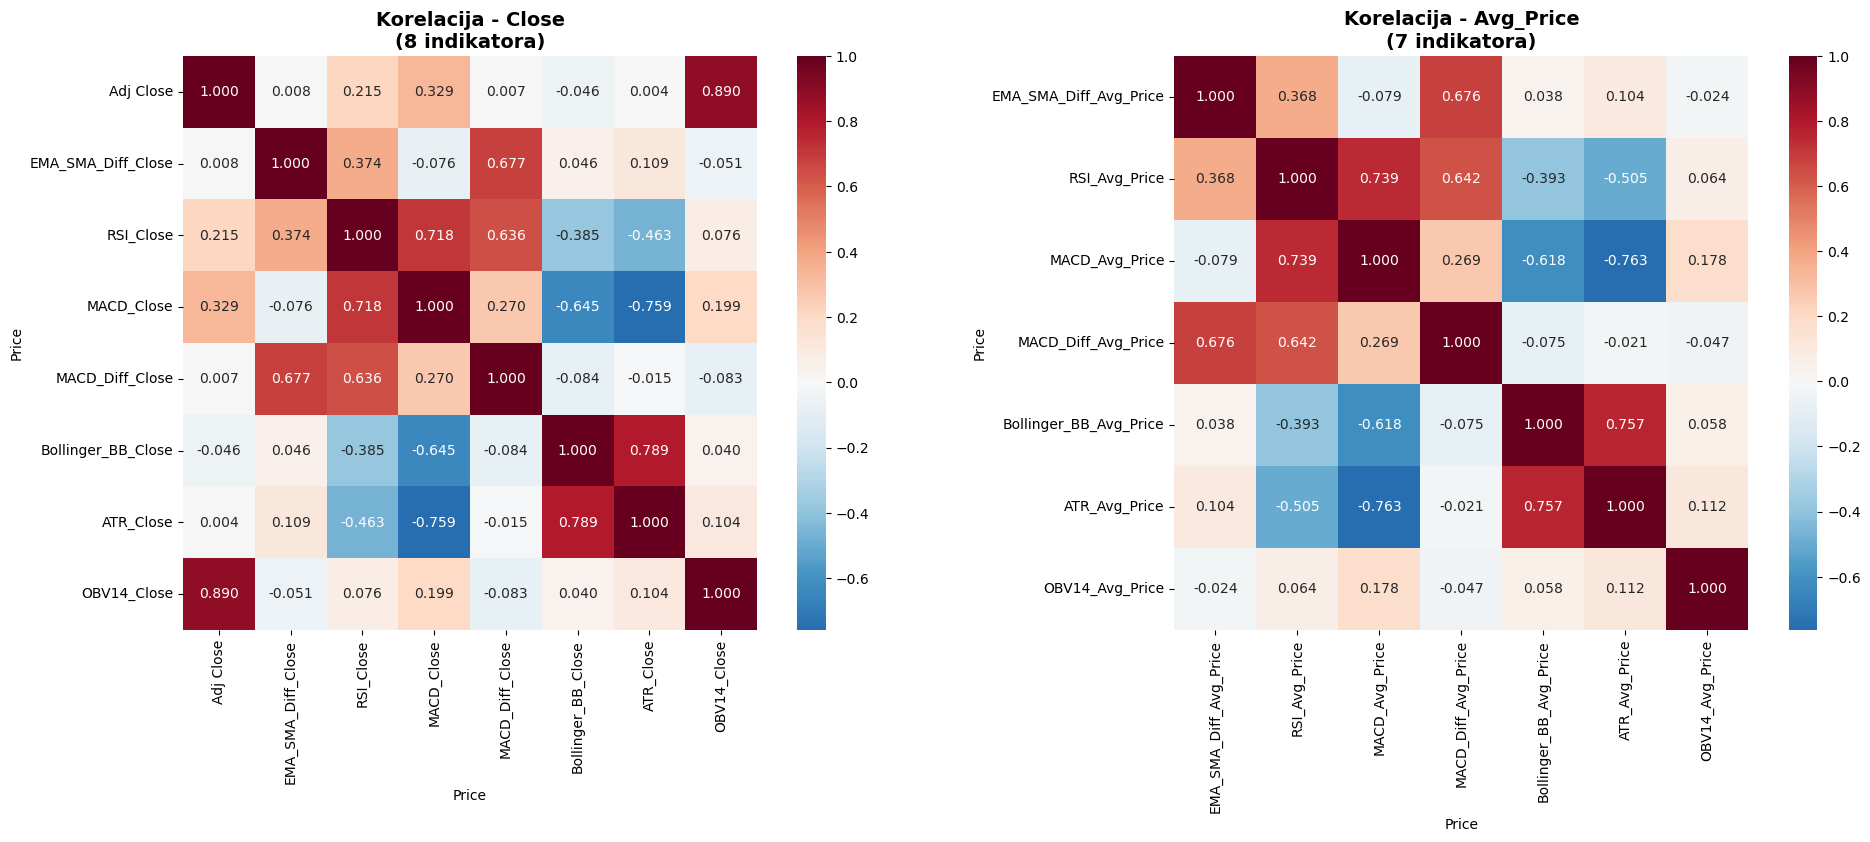


✅ ANALIZA ZAVRŠENA
   Close: 8 indikatora
   Avg_Price: 7 indikatora


In [135]:
def run_basic_correlation_analysis(df):
    """
    Osnovna korelaciona analiza - prikazuje samo ono što postoji
    """
    print("🔍 OSNOVNA KORELACIONA ANALIZA")
    print("=" * 50)
    
    # Proveri šta imamo
    all_columns = df.columns.tolist()
    
    # Indikatori za Close
    close_indicators = [col for col in all_columns if 'Close' in col and col != 'Close']
    print(f"Close indikatori ({len(close_indicators)}): {close_indicators}")
    
    # Indikatori za Avg_Price
    avg_price_indicators = [col for col in all_columns if 'Avg_Price' in col and col != 'Avg_Price']
    print(f"Avg_Price indikatori ({len(avg_price_indicators)}): {avg_price_indicators}")
    
    # Kreiraj plotove za ono što postoji
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Close heatmap
    if len(close_indicators) >= 2:
        close_corr = df[close_indicators].corr()
        sns.heatmap(close_corr, annot=True, fmt=".3f", cmap="RdBu_r", center=0, square=True, ax=axes[0])
        axes[0].set_title(f'Korelacija - Close\n({len(close_indicators)} indikatora)', fontsize=14, fontweight='bold')
    else:
        axes[0].text(0.5, 0.5, f'Nedovoljno indikatora\nza Close: {len(close_indicators)}', 
                    ha='center', va='center', fontsize=12)
        axes[0].set_title('Korelacija - Close', fontsize=14, fontweight='bold')
    
    # Avg_Price heatmap  
    if len(avg_price_indicators) >= 2:
        avg_corr = df[avg_price_indicators].corr()
        sns.heatmap(avg_corr, annot=True, fmt=".3f", cmap="RdBu_r", center=0, square=True, ax=axes[1])
        axes[1].set_title(f'Korelacija - Avg_Price\n({len(avg_price_indicators)} indikatora)', fontsize=14, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, f'Nedovoljno indikatora\nza Avg_Price: {len(avg_price_indicators)}', 
                    ha='center', va='center', fontsize=12)
        axes[1].set_title('Korelacija - Avg_Price', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ ANALIZA ZAVRŠENA")
    print(f"   Close: {len(close_indicators)} indikatora")
    print(f"   Avg_Price: {len(avg_price_indicators)} indikatora")

# POKRENI OVU FUNKCIJU UMESTO ONE KOJA DAJE GREŠKU
run_basic_correlation_analysis(sp500_ind)

🔍 OSNOVNA KORELACIONA ANALIZA
Close indikatori (8): ['Adj Close', 'EMA_SMA_Diff_Close', 'RSI_Close', 'MACD_Close', 'MACD_Diff_Close', 'Bollinger_BB_Close', 'ATR_Close', 'OBV14_Close']
Avg_Price indikatori (7): ['EMA_SMA_Diff_Avg_Price', 'RSI_Avg_Price', 'MACD_Avg_Price', 'MACD_Diff_Avg_Price', 'Bollinger_BB_Avg_Price', 'ATR_Avg_Price', 'OBV14_Avg_Price']


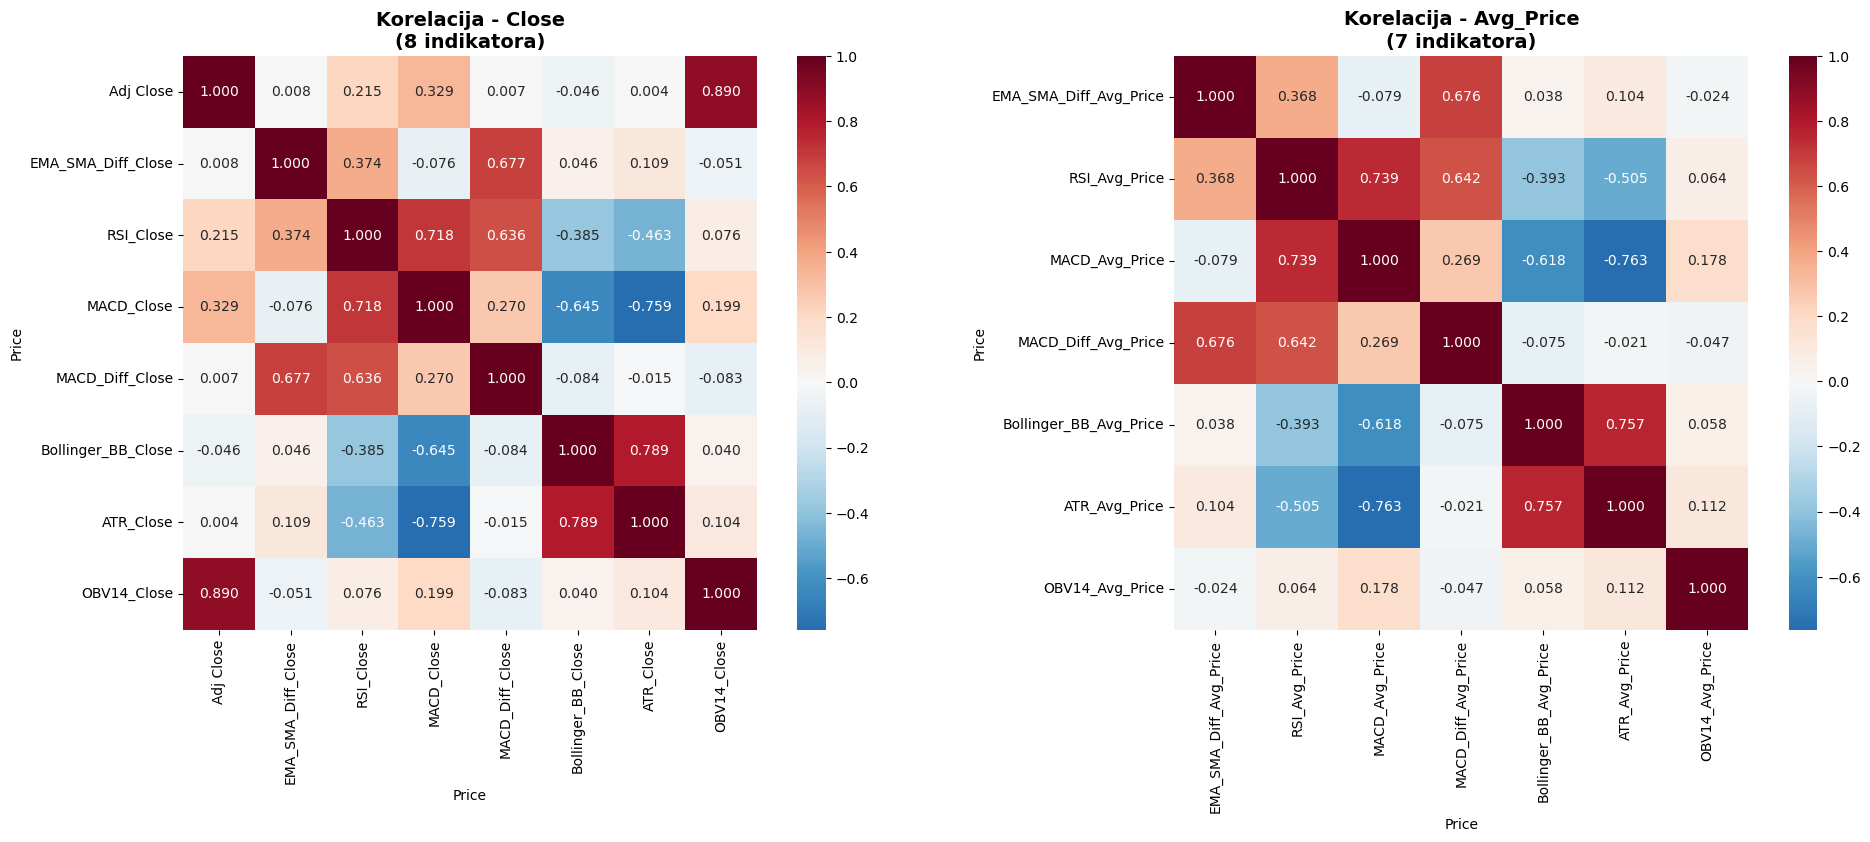


✅ ANALIZA ZAVRŠENA
   Close: 8 indikatora
   Avg_Price: 7 indikatora
Dostupni indikatori za Close: ['EMA_SMA_Diff_Close', 'RSI_Close', 'MACD_Close', 'MACD_Diff_Close', 'Bollinger_BB_Close', 'ATR_Close', 'OBV14_Close']
✅ Uspešno izračunate korelacije za Close: (7, 7) matrica
Dostupni indikatori za Avg_Price: ['EMA_SMA_Diff_Avg_Price', 'RSI_Avg_Price', 'MACD_Avg_Price', 'MACD_Diff_Avg_Price', 'Bollinger_BB_Avg_Price', 'ATR_Avg_Price', 'OBV14_Avg_Price']
✅ Uspešno izračunate korelacije za Avg_Price: (7, 7) matrica
KORELACIONA ANALIZA: Close vs Avg_Price
Dostupni indikatori za Close: ['EMA_SMA_Diff_Close', 'RSI_Close', 'MACD_Close', 'MACD_Diff_Close', 'Bollinger_BB_Close', 'ATR_Close', 'OBV14_Close']
✅ Uspešno izračunate korelacije za Close: (7, 7) matrica
Dostupni indikatori za Avg_Price: ['EMA_SMA_Diff_Avg_Price', 'RSI_Avg_Price', 'MACD_Avg_Price', 'MACD_Diff_Avg_Price', 'Bollinger_BB_Avg_Price', 'ATR_Avg_Price', 'OBV14_Avg_Price']
✅ Uspešno izračunate korelacije za Avg_Price: (7, 7) ma

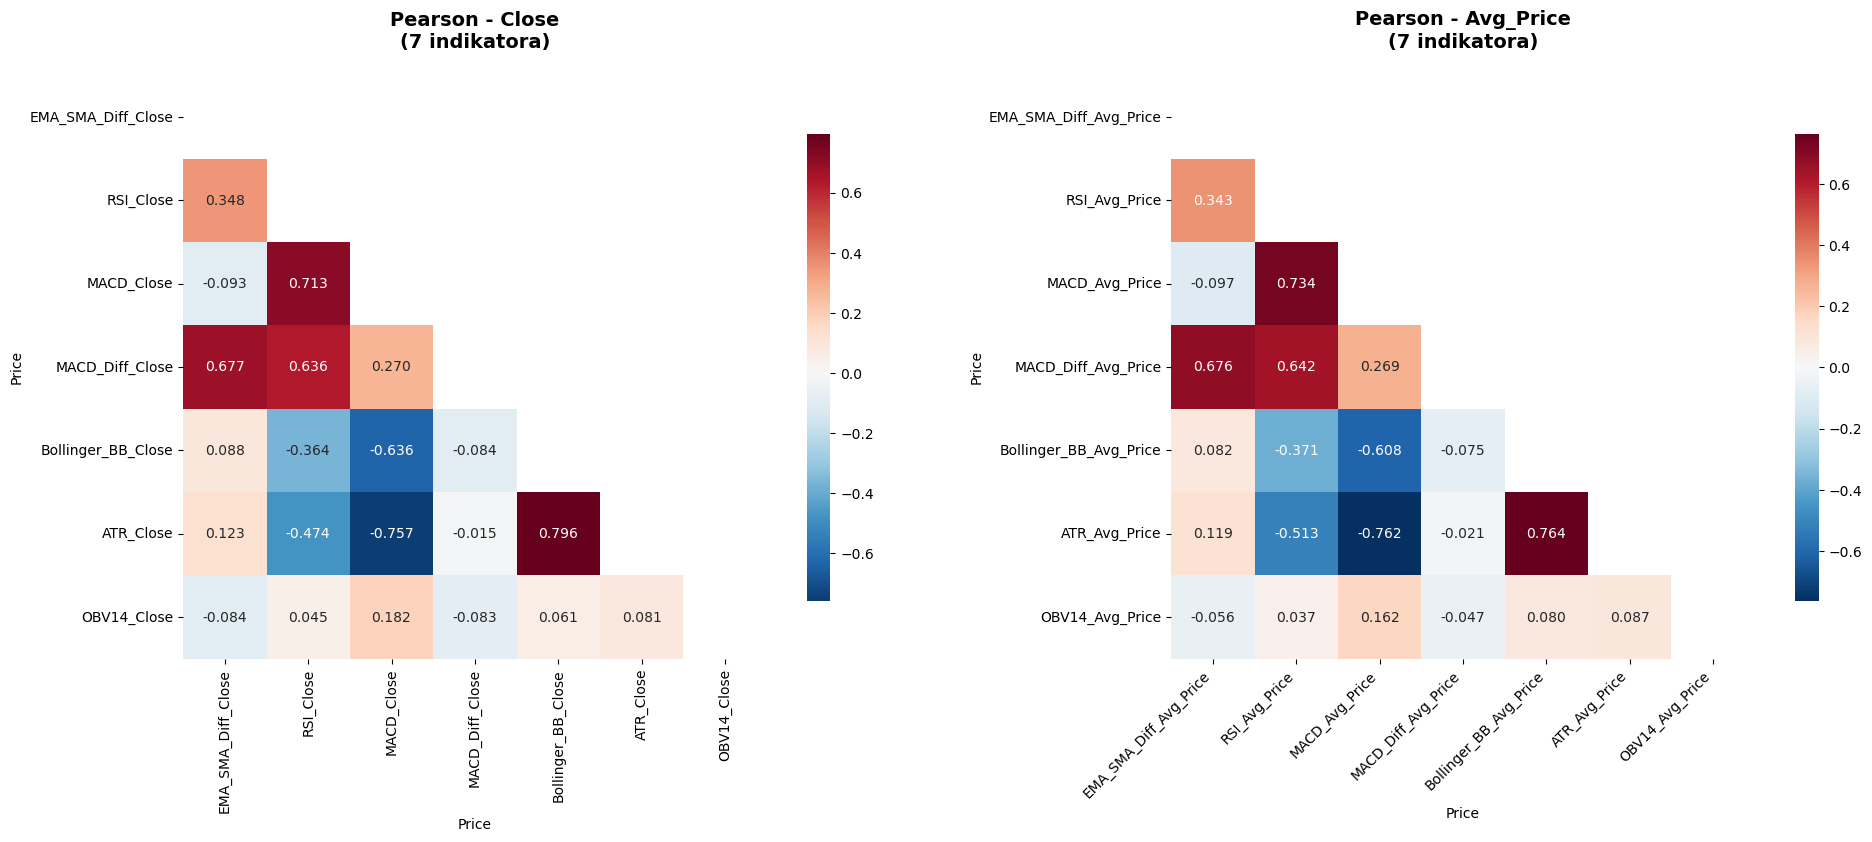

In [112]:
# Jednostavno pozovite:
results = run_basic_correlation_analysis(sp500_ind)

# Ili korak po korak:
close_analysis = create_correlation_analysis(sp500_ind, 'Close')
avg_price_analysis = create_correlation_analysis(sp500_ind, 'Avg_Price')

if close_analysis and avg_price_analysis:
    compare_correlations_close_vs_avgprice(sp500_ind)

**JAKA korelacija (slične vrednosti):**

RSI – MACD:           Close=0.718 vs Avg_Price=0.739

MACD – ATR:          Close=-0.759 vs Avg_Price=-0.763

Bollinger – ATR:     Close=0.789 vs Avg_Price=0.757

EMA-SMA – MACD_Diff: Close=0.677 vs Avg_Price=0.676

**NAJVEĆA RAZLIKA:**

RSI – MACD_Diff:     Close=0.636 vs Avg_Price=0.269  - Razlika: 0.367!

**Ostale razlike**

MACD – Bollinger:    Close=-0.645 vs Avg_Price=-0.618

RSI – ATR:          Close=-0.463 vs Avg_Price=-0.505

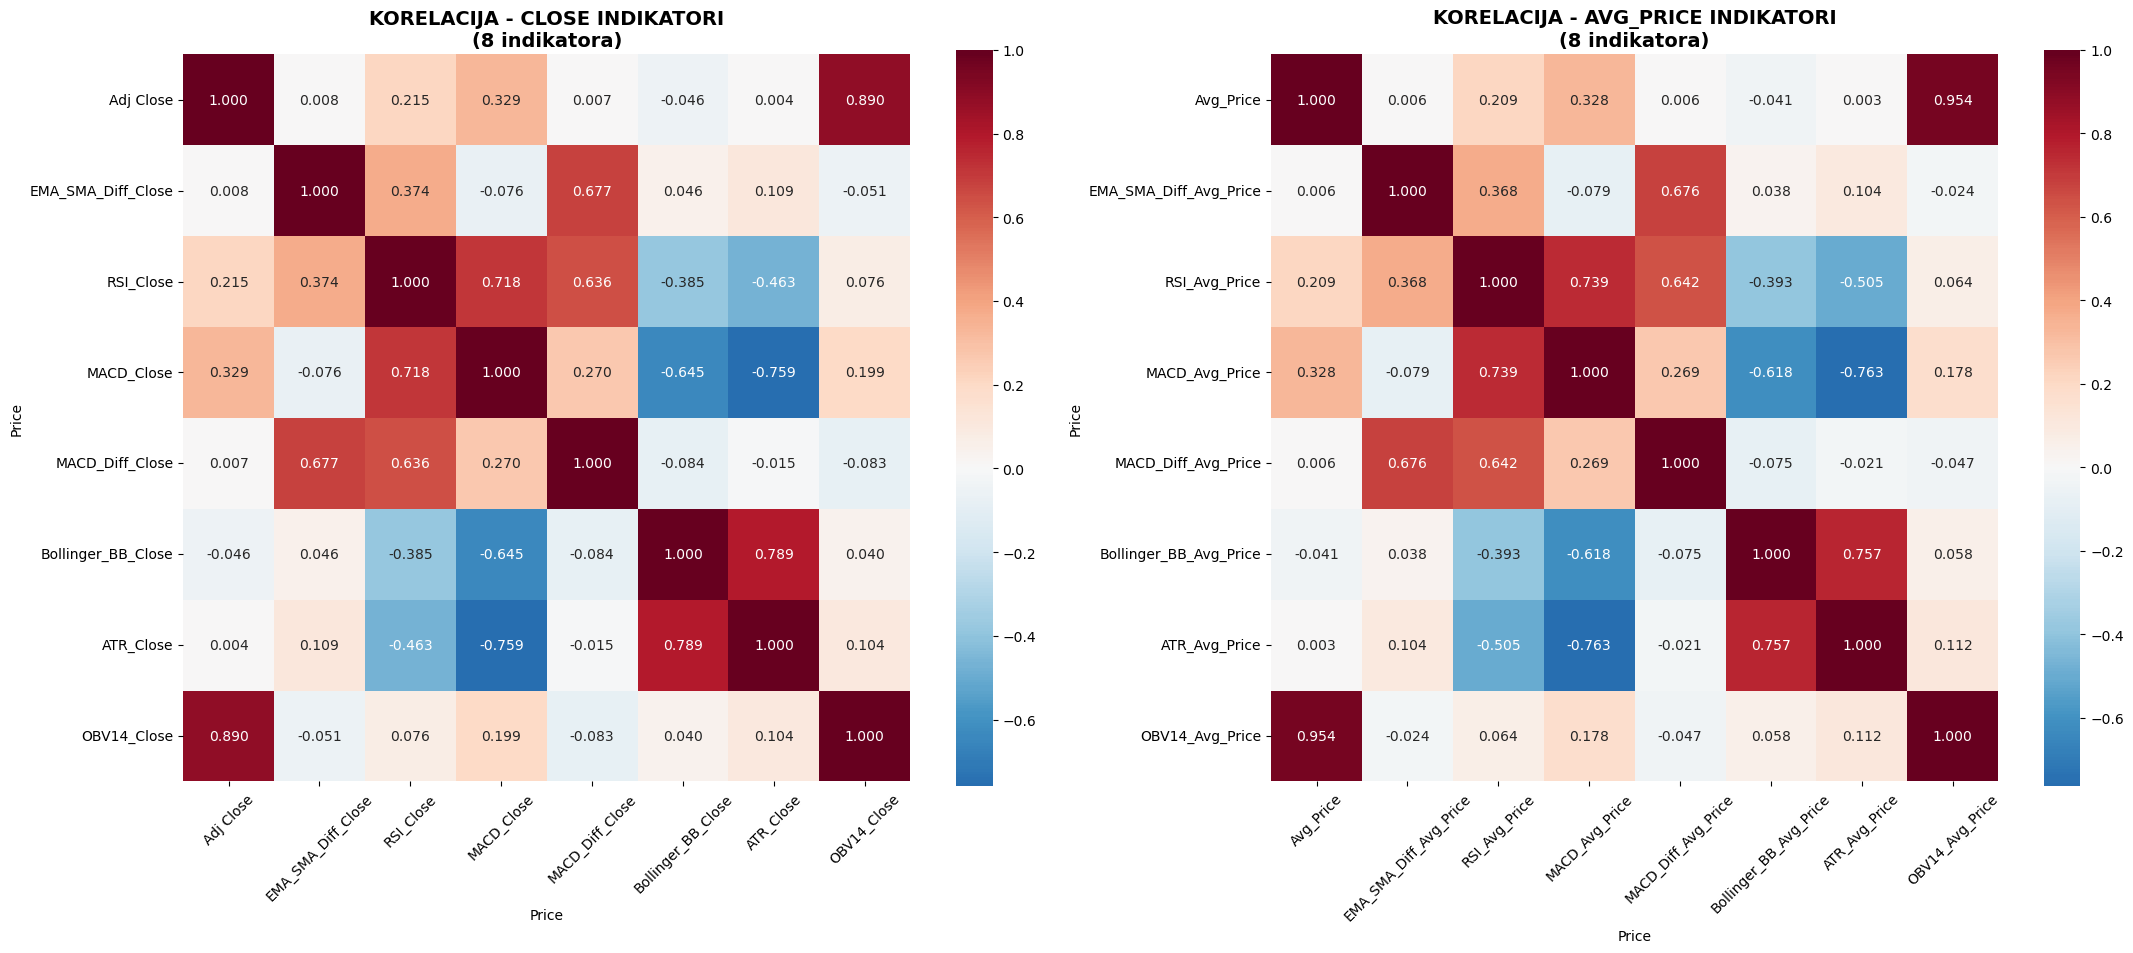

In [136]:
def create_comparison_heatmaps(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
    
    # Close indikatori
    close_indicators = ['Adj Close', 'EMA_SMA_Diff_Close', 'RSI_Close', 'MACD_Close', 
                       'MACD_Diff_Close', 'Bollinger_BB_Close', 'ATR_Close', 'OBV14_Close']
    close_corr = df[close_indicators].corr()
    
    sns.heatmap(close_corr, annot=True, fmt=".3f", cmap="RdBu_r", center=0, square=True, ax=ax1)
    ax1.set_title('KORELACIJA - CLOSE INDIKATORI\n(8 indikatora)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)
    
    # Avg_Price indikatori  
    avg_indicators = ['Avg_Price', 'EMA_SMA_Diff_Avg_Price', 'RSI_Avg_Price', 'MACD_Avg_Price',
                     'MACD_Diff_Avg_Price', 'Bollinger_BB_Avg_Price', 'ATR_Avg_Price', 'OBV14_Avg_Price']
    avg_corr = df[avg_indicators].corr()
    
    sns.heatmap(avg_corr, annot=True, fmt=".3f", cmap="RdBu_r", center=0, square=True, ax=ax2)
    ax2.set_title('KORELACIJA - AVG_PRICE INDIKATORI\n(8 indikatora)', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

create_comparison_heatmaps(sp500_ind)

# OSNOVNI LSTM 

Funkcija za podelu na trening i test

In [137]:
def prepare_lstm_data_with_date_split(dataset, target_col, sequence_length=60, split_date='2025-01-01'):
    """
    Priprema podatke za LSTM sa podelom po datumu
    """
    # Proveri da li dataset ima Date kolonu
    if 'Date' not in dataset.columns:
        raise ValueError("Dataset mora da ima 'Date' kolonu za podelu po datumu")
    
    # Konvertuj Date kolonu ako nije datetime
    dataset = dataset.copy()
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    
    # Podela po datumu
    train_data = dataset[dataset['Date'] < split_date]
    test_data = dataset[dataset['Date'] >= split_date]
    
    print(f"📅 PODELA PODATAKA:")
    print(f"   Trening: {train_data['Date'].min()} do {train_data['Date'].max()} ({len(train_data)} redova)")
    print(f"   Test:    {test_data['Date'].min()} do {test_data['Date'].max()} ({len(test_data)} redova)")
    
    # Uzmi samo numeričke kolone (isključi Date)
    numeric_cols = [col for col in dataset.columns if col != 'Date']
    
    # Kreiraj sekvence za trening
    X_train, y_train = [], []
    train_values = train_data[numeric_cols].values
    
    for i in range(sequence_length, len(train_values)):
        X_train.append(train_values[i-sequence_length:i])
        y_train.append(train_values[i, numeric_cols.index(target_col)])
    
    # Kreiraj sekvence za test
    X_test, y_test = [], []
    test_values = test_data[numeric_cols].values
    
    for i in range(sequence_length, len(test_values)):
        X_test.append(test_values[i-sequence_length:i])
        y_test.append(test_values[i, numeric_cols.index(target_col)])
    
    return (np.array(X_train), np.array(y_train), 
            np.array(X_test), np.array(y_test),
            train_data, test_data)

Funkcija za LSTM

In [146]:
def train_lstm_on_all_series_with_date_split(cleaned_datasets, sequence_length=60, split_date='2025-01-01'):
    """
    Trenira LSTM modele sa podelom po datumu
    """
    results = {}
    
    for price_name, dataset in cleaned_datasets.items():
        print(f"\n🚀 TRENIRAM LSTM ZA {price_name}...")
        print("=" * 50)
        
        # Odredi target kolonu
        if price_name == 'Avg_Price':
            target_col = 'Avg_Price'
        else:
            target_col = price_name  # 'Close', 'Open', etc.
        
        # Proveri da li dataset ima Date kolonu
        if 'Date' not in dataset.columns:
            print(f"⚠️  {price_name} nema Date kolonu - preskačem")
            continue
        
        # Pripremi podatke sa podelom po datumu
        X_train, y_train, X_test, y_test, train_data, test_data = prepare_lstm_data_with_date_split(
            dataset, target_col, sequence_length, split_date
        )
        
        # Proveri da li ima dovoljno podataka
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"⚠️  Nedovoljno podataka za {price_name} - preskačem")
            continue
        
        print(f"   Trening sekvence: {X_train.shape}")
        print(f"   Test sekvence:    {X_test.shape}")
        
        # Napravi i treniraj LSTM model
        model = create_lstm_model(X_train.shape[1], X_train.shape[2])
        
        print("   🏋️  Počinjem trening...")
        history = model.fit(X_train, y_train, 
                          epochs=30, batch_size=32,
                          validation_data=(X_test, y_test),
                          verbose=1,
                          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
        
        # Evaluacija
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        # Sačuvaj rezultate
        results[price_name] = {
            'model': model,
            'history': history,
            'predictions': predictions,
            'actual': y_test,
            'mse': mse,
            'mae': mae,
            'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test,
            'train_dates': train_data['Date'].iloc[sequence_length:].values,
            'test_dates': test_data['Date'].iloc[sequence_length:].values
        }
        
        print(f"✅ {price_name} završeno")
        print(f"   MSE: {mse:.6f}, MAE: {mae:.6f}")
    
    return results

Funkcija za prikaz rezultata

In [140]:
def plot_results_comparison(results):
    """
    Prikazuje uporedne rezultate svih modela
    """
    print("\n" + "="*60)
    print("📊 UPOREDNI REZULTATI SVIH MODELA")
    print("="*60)
    
    metrics = []
    for price_name, result in results.items():
        metrics.append({
            'Cena': price_name,
            'MSE': result['mse'],
            'MAE': result['mae'],
            'Trening_uzoraka': len(result['X_train']),
            'Test_uzoraka': len(result['X_test'])
        })
    
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.sort_values('MSE')
    
    print(metrics_df.to_string(index=False))
    
    # Prikaz grafika
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # MSE comparison
    ax1.bar(metrics_df['Cena'], metrics_df['MSE'], color='skyblue')
    ax1.set_title('MSE Comparison po Cenama')
    ax1.set_ylabel('Mean Squared Error')
    ax1.tick_params(axis='x', rotation=45)
    
    # MAE comparison  
    ax2.bar(metrics_df['Cena'], metrics_df['MAE'], color='lightcoral')
    ax2.set_title('MAE Comparison po Cenama')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

Pokretanje sa pravim rezultatima

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_lstm_model(time_steps, n_features):
    """
    Kreira LSTM model arhitekturu
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_steps, n_features)),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(25),
        Dense(1)  # Output - predviđena cena
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    print(f"   ✅ LSTM model kreiran: input_shape=({time_steps}, {n_features})")
    return model

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [149]:
# POKRENI SADA SA PRAVOM PODELOM:
results_all_features = train_lstm_on_all_series_with_date_split(
    cleaned_datasets, 
    sequence_length=60, 
    split_date='2025-01-01'
)

# PRIKAŽI REZULTATE
metrics_df = plot_results_comparison(results_all_features)

# SAČUVAJ NAJBOLJI MODEL
best_model_name = metrics_df.iloc[0]['Cena']
best_model = results_all_features[best_model_name]['model']
best_model.save(f'lstm_best_model_{best_model_name}.h5')

print(f"\n🎉 NAJBOLJI MODEL: {best_model_name}")
print(f"💾 Sačuvan kao: lstm_best_model_{best_model_name}.h5")


🚀 TRENIRAM LSTM ZA Open...
📅 PODELA PODATAKA:
   Trening: 2020-03-13 00:00:00 do 2024-12-31 00:00:00 (1209 redova)
   Test:    2025-01-02 00:00:00 do 2025-08-29 00:00:00 (165 redova)
   Trening sekvence: (1149, 60, 9)
   Test sekvence:    (105, 60, 9)
   ✅ LSTM model kreiran: input_shape=(60, 9)
   🏋️  Počinjem trening...
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 19604426.0000 - mae: 4374.7773 - val_loss: 35730776.0000 - val_mae: 5964.6245
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 19440596.0000 - mae: 4355.9888 - val_loss: 35471676.0000 - val_mae: 5942.8652
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 19225994.0000 - mae: 4331.2734 - val_loss: 35139488.0000 - val_mae: 5914.8511
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 18955652.0000 - mae: 4299.8525 - val_loss: 34721712.0000 - val_mae: 5879.4292
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 18618118.0000 - mae: 4260.6021 - val_loss: 34216960.0000 - val_mae:

KeyboardInterrupt: 

### Sa standardizacijom

In [159]:
def plot_results_comparison_safe(results):
    """
    Bezbedno prikazuje rezultate čak i ako je results prazan
    """
    print("\n" + "="*60)
    print("📊 UPOREDNI REZULTATI SVIH MODELA")
    print("="*60)
    
    # Proveri da li results nije prazan
    if not results:
        print("❌ NEMA REZULTATA - svi modeli su preskočeni")
        return None
    
    metrics = []
    for price_name, result in results.items():
        metrics.append({
            'Cena': price_name,
            'MSE': result['mse'],
            'MAE': result['mae'],
            'Overfitting_Gap': result.get('overfitting_gap', 0),
            'Trening_uzoraka': len(result.get('X_train', [])),
            'Test_uzoraka': len(result.get('X_test', []))
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Bezbedno sortiranje
    if len(metrics_df) > 0 and 'MSE' in metrics_df.columns:
        metrics_df = metrics_df.sort_values('MSE')
        print("📈 PERFORMANCE METRIKE:")
        print(metrics_df.to_string(index=False))
        
        # Prikaz grafika
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # MSE comparison
        ax1.bar(metrics_df['Cena'], metrics_df['MSE'], color='skyblue', alpha=0.7)
        ax1.set_title('MSE Comparison po Cenama\n(manje je bolje)')
        ax1.set_ylabel('Mean Squared Error')
        ax1.tick_params(axis='x', rotation=45)
        
        # MAE comparison  
        ax2.bar(metrics_df['Cena'], metrics_df['MAE'], color='lightcoral', alpha=0.7)
        ax2.set_title('MAE Comparison po Cenama\n(manje je bolje)')
        ax2.set_ylabel('Mean Absolute Error')
        ax2.tick_params(axis='x', rotation=45)
        
        # Overfitting gap
        ax3.bar(metrics_df['Cena'], metrics_df['Overfitting_Gap'], color='orange', alpha=0.7)
        ax3.set_title('Overfitting Gap\n(manje je bolje)')
        ax3.set_ylabel('Val Loss - Train Loss')
        ax3.axhline(y=0.1, color='red', linestyle='--', label='Overfitting threshold')
        ax3.tick_params(axis='x', rotation=45)
        ax3.legend()
        
        # Sample sizes
        ax4.bar(metrics_df['Cena'], metrics_df['Test_uzoraka'], color='lightgreen', alpha=0.7, label='Test')
        ax4.bar(metrics_df['Cena'], metrics_df['Trening_uzoraka'], color='blue', alpha=0.5, label='Trening')
        ax4.set_title('Veličine Uzoraka')
        ax4.set_ylabel('Broj sekvenci')
        ax4.tick_params(axis='x', rotation=45)
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Analiza overfitting-a
        print(f"\n🔍 ANALIZA OVERFITTING-A:")
        high_overfitting = metrics_df[metrics_df['Overfitting_Gap'] > 0.2]
        moderate_overfitting = metrics_df[(metrics_df['Overfitting_Gap'] > 0.1) & (metrics_df['Overfitting_Gap'] <= 0.2)]
        good_generalization = metrics_df[metrics_df['Overfitting_Gap'] <= 0.1]
        
        if len(high_overfitting) > 0:
            print(f"🚨 VISOK OVERFITTING: {list(high_overfitting['Cena'])}")
        if len(moderate_overfitting) > 0:
            print(f"⚠️  UMEREN OVERFITTING: {list(moderate_overfitting['Cena'])}")
        if len(good_generalization) > 0:
            print(f"✅ DOBRA GENERALIZACIJA: {list(good_generalization['Cena'])}")
            
    else:
        print("❌ Nema metrika za prikaz")
    
    return metrics_df

In [154]:
def dynamic_standardize_sequences_correct(X_train, y_train, X_test, y_test):
    """
    ISPRAVNA standardizacija - standardizuje i feature-e i target
    """
    # Standardizuj FEATURE-E (X)
    X_mean = np.mean(X_train, axis=(0, 1))
    X_std = np.std(X_train, axis=(0, 1))
    X_std = np.where(X_std == 0, 1, X_std)
    
    X_train_std = (X_train - X_mean) / X_std
    X_test_std = (X_test - X_mean) / X_std
    
    # Standardizuj TARGET (y) - OVO JE KLJUČNO!
    y_mean = np.mean(y_train)
    y_std = np.std(y_train)
    y_std = 1 if y_std == 0 else y_std
    
    y_train_std = (y_train - y_mean) / y_std
    y_test_std = (y_test - y_mean) / y_std
    
    standardization_params = {
        'X_mean': X_mean, 'X_std': X_std,
        'y_mean': y_mean, 'y_std': y_std
    }
    
    print(f"   Target standardizacija: mean={y_mean:.2f}, std={y_std:.2f}")
    
    return X_train_std, y_train_std, X_test_std, y_test_std, standardization_params

def inverse_standardize_predictions(predictions_std, y_mean, y_std):
    """
    Vraća predikcije u originalnu skalu
    """
    return (predictions_std * y_std) + y_mean

In [155]:
def train_lstm_on_all_series_with_correct_standardization(cleaned_datasets, sequence_length=60, split_date='2025-01-01'):
    """
    Trenira LSTM modele SA ISPRAVNOM STANDARDIZACIJOM
    """
    results = {}
    
    for price_name, dataset in cleaned_datasets.items():
        print(f"\n🚀 TRENIRAM LSTM ZA {price_name}...")
        print("=" * 50)
        
        # Odredi target kolonu
        if price_name == 'Avg_Price':
            target_col = 'Avg_Price'
        else:
            target_col = price_name
        
        if 'Date' not in dataset.columns:
            print(f"⚠️  {price_name} nema Date kolonu - preskačem")
            continue
        
        # Pripremi podatke
        X_train, y_train, X_test, y_test, train_data, test_data = prepare_lstm_data_with_date_split(
            dataset, target_col, sequence_length, split_date
        )
        
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"⚠️  Nedovoljno podataka za {price_name} - preskačem")
            continue
        
        print(f"   Trening sekvence: {X_train.shape}")
        print(f"   Test sekvence:    {X_test.shape}")
        
        # ✅ ISPRAVNA STANDARDIZACIJA
        print("   📊 Standardizujem podatke...")
        X_train_std, y_train_std, X_test_std, y_test_std, std_params = dynamic_standardize_sequences_correct(
            X_train, y_train, X_test, y_test
        )
        
        # Napravi i treniraj LSTM model
        model = create_lstm_model(X_train_std.shape[1], X_train_std.shape[2])
        
        print("   🏋️  Počinjem trening...")
        history = model.fit(X_train_std, y_train_std, 
                          epochs=50, batch_size=32,
                          validation_data=(X_test_std, y_test_std),
                          verbose=1,
                          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
        
        # Evaluacija - vrati predikcije u originalnu skalu
        predictions_std = model.predict(X_test_std)
        predictions = inverse_standardize_predictions(predictions_std, std_params['y_mean'], std_params['y_std'])
        
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        # Sačuvaj rezultate
        results[price_name] = {
            'model': model,
            'history': history,
            'predictions': predictions,
            'actual': y_test,
            'mse': mse,
            'mae': mae,
            'X_train': X_train_std, 'y_train': y_train_std,
            'X_test': X_test_std, 'y_test': y_test_std,
            'standardization_params': std_params,
            'train_dates': train_data['Date'].iloc[sequence_length:].values,
            'test_dates': test_data['Date'].iloc[sequence_length:].values
        }
        
        print(f"✅ {price_name} završeno")
        print(f"   MSE: {mse:.6f}, MAE: {mae:.6f}")
    
    return results

In [152]:
def predict_with_standardization(model, new_sequence, standardization_params):
    """
    Pravi predikcije sa standardizovanim podacima
    """
    mean = standardization_params['mean']
    std = standardization_params['std']
    
    # Standardizuj novu sekvencu
    new_sequence_std = (new_sequence - mean) / std
    
    # Napravi predikciju
    prediction_std = model.predict(new_sequence_std.reshape(1, *new_sequence_std.shape))
    
    return prediction_std[0][0]

In [156]:
# ZAUSTAVI TRENUTNI TRENING I POKRENI ISPRAVNU VERZIJU
print("🔄 POKREĆEM ISPRAVNU STANDARDIZACIJU...")
results_correct = train_lstm_on_all_series_with_correct_standardization(
    cleaned_datasets,
    sequence_length=60,
    split_date='2025-01-01'
)

# OVO ĆE SADA DAVATI REALNE REZULTATE!
metrics_df = plot_results_comparison_safe(results_correct)

🔄 POKREĆEM ISPRAVNU STANDARDIZACIJU...

🚀 TRENIRAM LSTM ZA Open...
📅 PODELA PODATAKA:
   Trening: 2020-03-13 00:00:00 do 2024-12-31 00:00:00 (1209 redova)
   Test:    2025-01-02 00:00:00 do 2025-08-29 00:00:00 (165 redova)
   Trening sekvence: (1149, 60, 9)
   Test sekvence:    (105, 60, 9)
   📊 Standardizujem podatke...
   Target standardizacija: mean=4380.42, std=682.54
   ✅ LSTM model kreiran: input_shape=(60, 9)
   🏋️  Počinjem trening...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.1879 - mae: 0.2950 - val_loss: 0.7762 - val_mae: 0.8401
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0363 - mae: 0.1466 - val_loss: 0.7751 - val_mae: 0.8255
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0296 - mae: 0.1331 - val_loss: 0.5817 - val_mae: 0.6928
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0263 - mae: 0.1233 - val_loss: 0.5201 - val_mae: 0.6730
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0247 - mae: 0.1215 - val

NameError: name 'plot_results_comparison_safe' is not defined

### Sa regularizacijom

In [160]:
def create_lstm_model_regularized(time_steps, n_features):
    """
    LSTM model sa regularizacijom protiv overfitting-a
    """
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(time_steps, n_features), 
             dropout=0.2, recurrent_dropout=0.2),
        LSTM(32, return_sequences=True, 
             dropout=0.2, recurrent_dropout=0.2),
        LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print(f"   ✅ REGULARIZOVANI LSTM model kreiran")
    return model

In [165]:
def train_lstm_regularized(cleaned_datasets, sequence_length=60, split_date='2025-01-01'):
    """
    Trenira LSTM sa jačom regularizacijom protiv overfitting-a
    """
    results = {}


    for price_name, dataset in cleaned_datasets.items():
        print(f"\n🚀 TRENIRAM REGULARIZOVANI LSTM ZA {price_name}...")
        print("=" * 50)
        
        if price_name == 'Avg_Price':
            target_col = 'Avg_Price'
        else:
            target_col = price_name
        
        if 'Date' not in dataset.columns:
            print(f"⚠️  {price_name} nema Date kolonu - preskačem")
            continue
        
        # Pripremi podatke
        X_train, y_train, X_test, y_test, train_data, test_data = prepare_lstm_data_with_date_split(
            dataset, target_col, sequence_length, split_date
        )
        
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"⚠️  Nedovoljno podataka za {price_name} - preskačem")
            continue
        
        print(f"   Trening sekvence: {X_train.shape}")
        print(f"   Test sekvence:    {X_test.shape}")
        
        # Standardizacija
        print("   📊 Standardizujem podatke...")
        X_train_std, y_train_std, X_test_std, y_test_std, std_params = dynamic_standardize_sequences_correct(
            X_train, y_train, X_test, y_test
        )
        
        # Koristi REGULARIZOVANI model
        model = create_lstm_model_regularized(X_train_std.shape[1], X_train_std.shape[2])
        
        # Jači EarlyStopping
        early_stop = EarlyStopping(
            monitor='val_loss', 
            patience=15, 
            min_delta=0.01,
            restore_best_weights=True,
            verbose=1,
            baseline=None
        )
        
        print("   🏋️  Počinjem trening sa regularizacijom...")
        history = model.fit(X_train_std, y_train_std, 
                          epochs=100,  # Više epoch-a ali sa early stopping
                          batch_size=32,
                          validation_data=(X_test_std, y_test_std),
                          verbose=1,
                          callbacks=[early_stop])
        
        # Evaluacija
        predictions_std = model.predict(X_test_std)
        predictions = inverse_standardize_predictions(predictions_std, std_params['y_mean'], std_params['y_std'])
        
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        # Analiza overfitting-a
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        overfitting_gap = final_val_loss - final_train_loss
        
        print(f"✅ {price_name} završeno")
        print(f"   MSE: {mse:.6f}, MAE: {mae:.6f}")
        print(f"   Overfitting gap: {overfitting_gap:.4f} {'🚨' if overfitting_gap > 0.1 else '✅'}")
        
        results[price_name] = {
            'model': model,
            'history': history,
            'predictions': predictions,
            'actual': y_test,
            'mse': mse, 'mae': mae,
            'overfitting_gap': overfitting_gap,
            'standardization_params': std_params
        }
    
    return results

In [166]:
# ZAUSTAVI TRENUTNI I POKRENI REGULARIZOVANU VERZIJU
print("🔄 POKREĆEM REGULARIZOVANI MODEL...")
results_regularized = train_lstm_regularized(
    cleaned_datasets,
    sequence_length=60,
    split_date='2025-01-01'
)

# UPOREDI REZULTATE
print("\n📊 POREDJENJE OVERFITTING-A:")
for price_name, result in results_regularized.items():
    gap = result['overfitting_gap']
    status = "🚨 VISOK OVERFITTING" if gap > 0.2 else "⚠️  UMEREN OVERFITTING" if gap > 0.1 else "✅ DOBRA GENERALIZACIJA"
    print(f"{price_name}: gap={gap:.4f} - {status}")

🔄 POKREĆEM REGULARIZOVANI MODEL...

🚀 TRENIRAM REGULARIZOVANI LSTM ZA Open...
📅 PODELA PODATAKA:
   Trening: 2020-03-13 00:00:00 do 2024-12-31 00:00:00 (1209 redova)
   Test:    2025-01-02 00:00:00 do 2025-08-29 00:00:00 (165 redova)
   Trening sekvence: (1149, 60, 9)
   Test sekvence:    (105, 60, 9)
   📊 Standardizujem podatke...
   Target standardizacija: mean=4380.42, std=682.54
   ✅ REGULARIZOVANI LSTM model kreiran
   🏋️  Počinjem trening sa regularizacijom...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.5058 - mae: 0.5360 - val_loss: 1.7484 - val_mae: 1.2402
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.2767 - mae: 0.3854 - val_loss: 1.4660 - val_mae: 1.1361
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.2310 - mae: 0.3585 - val_loss: 1.0021 - val_mae: 0.9602
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.2123 - mae: 0.3370 - val_loss: 1.6791 - val_mae: 1.2515
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - 

KeyboardInterrupt: 

### Poboljsana verzija

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print("✅ Svi importovi uspešno učitani")

✅ Svi importovi uspešno učitani


In [172]:
def create_lstm_model_fixed(time_steps, n_features):
    """
    ISPRAVLJENI LSTM model - MANJE KOMPLEKSNOSTI
    """
    model = Sequential([
        # SAMO 2 LSTM sloja umesto 3
        LSTM(32, return_sequences=True, input_shape=(time_steps, n_features), 
             dropout=0.3, recurrent_dropout=0.3),  # POVEĆAJ dropout
        LSTM(16, dropout=0.3, recurrent_dropout=0.3),  # MANJE neurona
        Dense(8, activation='relu'),
        Dropout(0.4),  # POVEĆAJ dropout
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print(f"   ✅ ISPRAVLJENI LSTM model kreiran")
    return model

def create_fixed_early_stopping():
    """
    ISPRAVLJENI EarlyStopping - NEĆE PREURANJENO ZAUSTAVITI
    """
    return EarlyStopping(
        monitor='val_loss', 
        patience=25,           # POVEĆAJ NA 25
        min_delta=0.02,        # POVEĆAJ min_delta
        restore_best_weights=True,
        verbose=1,
        baseline=None
    )

In [178]:
def train_lstm_fixed(cleaned_datasets, sequence_length=60, split_date='2025-01-01'):
    """
    ISPRAVLJENA funkcija za trening SA ISPRAVNOM EVALUACIJOM
    """
    results = {}

    for price_name, dataset in cleaned_datasets.items():
        print(f"\n🎯 TRENIRAM ISPRAVLJENI LSTM ZA {price_name}...")
        print("=" * 60)
        
        if price_name == 'Avg_Price':
            target_col = 'Avg_Price'
        else:
            target_col = price_name
        
        if 'Date' not in dataset.columns:
            print(f"⚠️  {price_name} nema Date kolonu - preskačem")
            continue
        
        # Pripremi podatke
        X_train, y_train, X_test, y_test, train_data, test_data = prepare_lstm_data_with_date_split(
            dataset, target_col, sequence_length, split_date
        )
        
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"⚠️  Nedovoljno podataka za {price_name} - preskačem")
            continue
        
        print(f"   Trening sekvence: {X_train.shape}")
        print(f"   Test sekvence:    {X_test.shape}")
        
        # Standardizacija
        print("   📊 Standardizujem podatke...")
        X_train_std, y_train_std, X_test_std, y_test_std, std_params = dynamic_standardize_sequences_correct(
            X_train, y_train, X_test, y_test
        )
        
        # KORISTI ISPRAVLJENI MODEL
        model = create_lstm_model_fixed(X_train_std.shape[1], X_train_std.shape[2])
        
        # PAMETNI CALLBACKS
        callbacks = create_smart_callbacks()
        
        print("   🏋️  Počinjem ISPRAVLJENI trening...")
        history = model.fit(X_train_std, y_train_std, 
                          epochs=100,
                          batch_size=32,
                          validation_data=(X_test_std, y_test_std),
                          verbose=1,
                          callbacks=callbacks)
        
        # Pronađi NAJBOLJI epoch (ne poslednji!)
        best_epoch = np.argmin(history.history['val_loss'])
        best_val_loss = history.history['val_loss'][best_epoch]
        best_train_loss = history.history['loss'][best_epoch]
        
        # ISPRAVNA EVALUACIJA
        predictions_std = model.predict(X_test_std)
        
        # ISPRAVNA KONVERZIJA NAZAD U ORIGINALNU SKALU
        predictions = (predictions_std * std_params['y_std']) + std_params['y_mean']
        
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        # Analiza
        overfitting_gap = best_val_loss - best_train_loss
        
        print(f"✅ {price_name} ZAVRŠEN")
        print(f"   Najbolji epoch: {best_epoch + 1}")
        print(f"   Najbolji val loss: {best_val_loss:.4f}")
        print(f"   MSE: {mse:.2f}")
        print(f"   MAE: {mae:.2f} points")  # OVO JE PRAVA VREDNOST!
        print(f"   Overfitting gap: {overfitting_gap:.4f}")
        
        results[price_name] = {
            'model': model,
            'history': history,
            'predictions': predictions,
            'actual': y_test,
            'mse': mse, 'mae': mae,
            'overfitting_gap': overfitting_gap,
            'standardization_params': std_params,
            'best_epoch': best_epoch + 1
        }
    
    return results

In [180]:
def create_smart_callbacks():
    """
    Kombinuje EarlyStopping i ReduceLROnPlateau
    """
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=25,
        min_delta=0.02,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.0001,
        verbose=1
    )
    
    return [early_stop, reduce_lr]

In [181]:
# POKRENI SA ISPRAVLJENOM FUNKCIJOM
print("🔄 POKREĆEM ISPRAVLJENU VERZIJU...")
results_fixed = train_lstm_fixed(
    cleaned_datasets,
    sequence_length=60,
    split_date='2025-01-01'
)

# ANALIZIRAJ REZULTATE
print("\n📊 ANALIZA ISPRAVLJENIH REZULTATA:")
for price_name, result in results_fixed.items():
    real_mae = result['mae'] * result['standardization_params']['y_std']
    print(f"{price_name}:")
    print(f"  MAE: {real_mae:.0f} points")
    print(f"  Najbolji epoch: {result['best_epoch']}")
    print(f"  Overfitting gap: {result['overfitting_gap']:.4f}")

🔄 POKREĆEM ISPRAVLJENU VERZIJU...

🎯 TRENIRAM ISPRAVLJENI LSTM ZA Open...
📅 PODELA PODATAKA:
   Trening: 2020-03-13 00:00:00 do 2024-12-31 00:00:00 (1209 redova)
   Test:    2025-01-02 00:00:00 do 2025-08-29 00:00:00 (165 redova)
   Trening sekvence: (1149, 60, 9)
   Test sekvence:    (105, 60, 9)
   📊 Standardizujem podatke...
   Target standardizacija: mean=4380.42, std=682.54
   ✅ ISPRAVLJENI LSTM model kreiran
   🏋️  Počinjem ISPRAVLJENI trening...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - loss: 0.9650 - mae: 0.7426 - val_loss: 5.6865 - val_mae: 2.3237 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.7515 - mae: 0.6223 - val_loss: 5.3751 - val_mae: 2.2584 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.6624 - mae: 0.5793 - val_loss: 4.8205 - val_mae: 2.1338 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.5514 - mae: 0.5289 - val_loss: 3.8643 - val_mae: 1.90

# Konačna verzija

In [2]:
def dynamic_standardize_sequences_no_leakage(X_train, y_train, X_test, y_test):
    """
    STANDARDIZACIJA BEZ DATA LEAKAGE
    """
    # Standardizuj FEATURE-E (X) - SAMO TRENING
    X_mean = np.mean(X_train, axis=(0, 1))
    X_std = np.std(X_train, axis=(0, 1))
    X_std = np.where(X_std == 0, 1, X_std)
    
    X_train_std = (X_train - X_mean) / X_std
    # X_test se NE standardizuje - koristi se direktno!
    
    # Standardizuj TARGET (y) - SAMO TRENING  
    y_mean = np.mean(y_train)
    y_std = np.std(y_train)
    y_std = 1 if y_std == 0 else y_std
    
    y_train_std = (y_train - y_mean) / y_std
    # y_test se NE standardizuje - koristi se direktno!
    
    standardization_params = {
        'X_mean': X_mean, 'X_std': X_std,
        'y_mean': y_mean, 'y_std': y_std
    }
    
    print(f"   Target standardizacija: mean={y_mean:.2f}, std={y_std:.2f}")
    
    # ✅ BEZ LEAKAGE: vrati NEstandardizovane test podatke
    return X_train_std, y_train_std, X_test, y_test, 

In [3]:
def train_without_leakage(cleaned_datasets, sequence_length=60, split_date='2025-01-01'):
    """
    Treniranje BEZ DATA LEAKAGE
    """
    results = {}

    for price_name, dataset in cleaned_datasets.items():
        print(f"\n🎯 TRENIRAM BEZ LEAKAGE ZA {price_name}...")
        print("=" * 60)
        
        # Pripremi podatke
        X_train, y_train, X_test, y_test, train_data, test_data = prepare_lstm_data_with_date_split(
            dataset, price_name, sequence_length, split_date
        )
        
        # STANDARDIZACIJA BEZ LEAKAGE
        X_train_std, y_train_std, X_test_raw, y_test_raw, std_params = dynamic_standardize_sequences_no_leakage(
            X_train, y_train, X_test, y_test
        )
        
        # Treniraj model na standardizovanim TRENING podacima
        model = create_lstm_model_fixed(X_train_std.shape[1], X_train_std.shape[2])
        
        history = model.fit(X_train_std, y_train_std, 
                          epochs=100,
                          batch_size=32,
                          validation_split=0.2,  # Koristi validaciju iz treninga
                          verbose=1,
                          callbacks=create_smart_callbacks())
        
        # ✅ ISPRAVNA PREDIKCIJA: Standardizuj test podatke PRED predikciju
        X_test_std = (X_test_raw - std_params['X_mean']) / std_params['X_std']
        predictions_std = model.predict(X_test_std)
        
        # Vrati predikcije u originalnu skalu
        predictions = (predictions_std * std_params['y_std']) + std_params['y_mean']
        
        # Evaluacija na NEstandardizovanim test podacima
        mse = mean_squared_error(y_test_raw, predictions)
        mae = mean_absolute_error(y_test_raw, predictions)
        
        print(f"✅ {price_name} BEZ LEAKAGE")
        print(f"   MAE: {mae:.2f} points")
        print(f"   Greška: {(mae/4500)*100:.1f}%")
        
        results[price_name] = {
            'model': model, 'predictions': predictions,
            'actual': y_test_raw, 'mse': mse, 'mae': mae
        }
    
    return results

In [4]:
# ZAUSTAVI TRENUTNI I POKRENI BEZ LEAKAGE
print("🔄 POKREĆEM BEZ DATA LEAKAGE...")
results_no_leakage = train_without_leakage(
    cleaned_datasets,
    sequence_length=60,
    split_date='2025-01-2025'
)

🔄 POKREĆEM BEZ DATA LEAKAGE...


NameError: name 'cleaned_datasets' is not defined

# Probna verzija

### Dodavanje indikatora bazirano na Avg_Price varijabli

### DataSet sa Avg_Price targetom

#### Čistija

#### Proširena